## Кейс: Создание прогнозной модели для мобильного приложения: предсказание оценки пользователя (от 1 до 5) мобильному приложению</font>

**Компания**: пенсионный фонд, предоставляющий клиентам цифровые сервисы для управления пенсионными накоплениями.

**Продукт**: мобильное приложение фонда, которое позволяет пользователям получать персональную информацию, оформлять услуги и отслеживать пенсионные выплаты. Задача решается в рамках цифровой трансформации фонда, направленной на повышение удобства и удовлетворенности граждан при взаимодействии с госуслугами.

**Проблема продукта** Несмотря на рост цифровизации, часть пользователей остается недовольной функциональностью или стабильностью приложения, что приводит к низким оценкам и жалобам. Это мешает фонду объективно оценивать качество предоставляемых электронных услуг и снижает доверие к цифровой инфраструктуре.

**Необходимо:**

1. Изучить датасет, провести EDA, предоставить бизнес-заказчикам практические инсайты, поддерживающие принятие решений на основе данных.

2. Сформулировать аналитические выводы для ML-отдела для последующей разработки модели, прогнозирующей прибыльность рекламного показа.

3. Подготовить дашборд, который содержит графики и визуализации, отражающие ключевые выводы анализа данных. Он должен демонстрировать выявленные закономерности и инсайты, быть понятным для пользователей без технической подготовки и служить инструментом для принятия решений на основе данных.

4. Подготовить все артефакты работы и презентацию с решения:
    - Ноутбук .ipynb с расчетами и визуализациями инсайтов.
    - Дашборд на платформе gradio.app.
    - Презентацию для защиты решения (.pdf).

*Датасет содержит:*

|user_id |survey_creation_dt|survey_response_dt|language|age|gender|tenure_years|user_income|csat_level|
|--------|------------------|------------------|--------|---|------|------------|-----------|----------|
|id пользователя|дата создания опроса|дата ответа на опрос|язык пользователя|возраст пользователя|пол пользователя|стаж пользователя в годах|доход пользователя|оценка пользователя|

---

## I. Загрузка данных. Проведение EDA.

---
**1. Импорт библиотек**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**2. Загрузка данных**

In [52]:
# Загружаем датасет
app_survey = pd.read_csv('app_survey.csv')

# Проверяем первые 5 строк датасета
print("Первые 5 строк:")
app_survey.head()

Первые 5 строк:


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income
0,user_00000,2025-04-28 16:01:51,2025-05-07 03:24:28,1,RU,35-44,M,21.105392,10000-25000
1,user_00001,2025-04-25 03:02:23,2025-04-29 13:12:29,5,RU,35-44,M,21.129793,68000-100000
2,user_00002,2025-04-30 11:02:14,2025-04-20 21:09:01,5,RU,45-54,M,21.098074,NaN
3,user_00003,2025-04-25 09:32:18,2025-04-26 19:51:12,5,RU,45-54,M,21.115544,25000-44000
4,user_00004,2025-04-30 08:32:06,2025-05-01 18:33:35,5,RU,45-54,M,21.127961,44000-68000


**3. Первичный анализ данных**

In [53]:
# Определяем размер датасета
print("Размер датасета:", app_survey.shape)

# Собираем общую информацию о данных
print("\nОбщая информация о датасете:")
app_survey.info()

# Выводим статистику по столбцам
print("\nСтатистика по  столбцам:")
app_survey.describe(include='all')

Размер датасета: (42387, 9)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42387 entries, 0 to 42386
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             42387 non-null  object 
 1   survey_creation_dt  42387 non-null  object 
 2   survey_response_dt  42387 non-null  object 
 3   csat_level          42387 non-null  int64  
 4   language            35561 non-null  object 
 5   age                 40939 non-null  object 
 6   gender              42387 non-null  object 
 7   tenure_years        42387 non-null  float64
 8   user_income         32013 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.9+ MB

Статистика по  столбцам:


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income
count,42387,42387,42387,42387.000000,35561,40939,42387,42387.000000,32013
unique,40065,40961,41983,NaN,1,5,2,NaN,6
top,user_29032,2025-05-07 06:32:14,2025-05-10 13:07:39,NaN,RU,35-44,M,NaN,10000-25000
freq,5,3,3,NaN,35561,11835,32413,NaN,18354
mean,NaN,NaN,NaN,4.102767,NaN,NaN,NaN,9.801147,NaN
std,NaN,NaN,NaN,1.506246,NaN,NaN,NaN,7.591410,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,2.132807,NaN
50%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,9.308819,NaN
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,16.941052,NaN


**4. Анализ пропусков значений в датасете**

,Количество пропусков,Процент пропусков
user_id,0,0.00
survey_creation_dt,0,0.00
survey_response_dt,0,0.00
csat_level,0,0.00
language,6826,16.10
age,1448,3.42
gender,0,0.00
tenure_years,0,0.00
user_income,10374,24.47


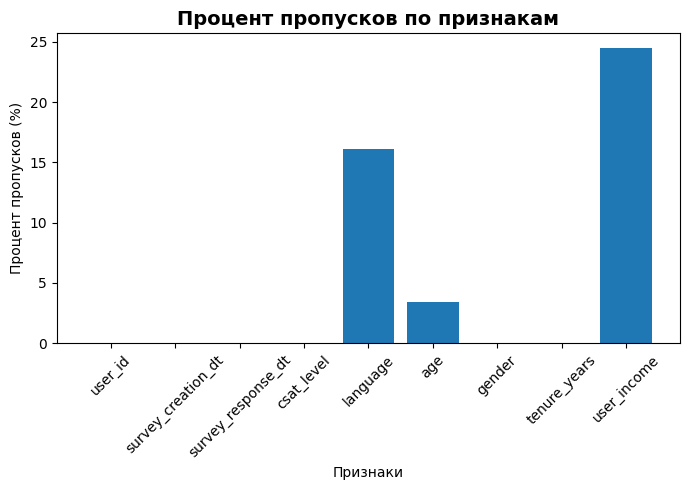

In [54]:
# Анализ пропусков
missing_data = app_survey.isnull().sum()
missing_percent = (missing_data / len(app_survey)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_data,
    'Процент пропусков': missing_percent.round(2)
})

display(missing_df)

# Визуализация пропусков
fig, ax = plt.subplots(1, figsize=(7, 5))

bars = ax.bar(missing_df.index, missing_df['Процент пропусков'])
ax.set_title('Процент пропусков по признакам', fontsize=14, fontweight='bold')
ax.set_xlabel('Признаки')
ax.set_ylabel('Процент пропусков (%)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**5. Анализ дубликатов в колонке user_id**

In [55]:
# Анализ дубликатов
duplicate_rows = app_survey.duplicated().sum()
duplicate_users = app_survey['user_id'].duplicated().sum()

print(f"Полные дубликаты строк: {duplicate_rows}")

if duplicate_users > 0:
    duplicate_counts = app_survey['user_id'].value_counts()
    repeated_users = duplicate_counts[duplicate_counts > 1]
    print(f"\nПользователи с несколькими откликами ({len(repeated_users)} пользователей):")
    print(f"Максимальное количество откликов: {repeated_users.max()}")

Полные дубликаты строк: 0

Пользователи с несколькими откликами (2049 пользователей):
Максимальное количество откликов: 5


**6. Предобработка данных**

*Преобразуем даты в формат datetime, заполним пропуски, создадим признак времени отклика и проведем порядковое кодирование категориальных переменных.*

In [56]:
# Сохраняем копию оригинального датасета
app_survey_original = app_survey.copy()

# Преобразовываем дату
app_survey['survey_creation_dt'] = pd.to_datetime(app_survey['survey_creation_dt'])
app_survey['survey_response_dt'] = pd.to_datetime(app_survey['survey_response_dt'])

# Обрабатываем пропуски
# Для language заполняем пропуски - "Неизвестно"
app_survey['language'] = app_survey['language'].fillna('Неизвестно')

# Для age заполняем пропуски - "Неизвестно"
app_survey['age'] = app_survey['age'].fillna('Неизвестно')

# Для user_income - создаем категорию "Не указан"
app_survey['user_income'] = app_survey['user_income'].fillna('Не указан')

# Создаем новые признаки из даты
# Время ответа (в днях)
app_survey['response_time_days'] = (
    app_survey['survey_response_dt'] - app_survey['survey_creation_dt']
).dt.days

# Преобразовываем порядковые признаки
# Порядок для возраста
age_order = ['18-24', '25-34', '35-44', '45-54', '55+', 'Неизвестно']
app_survey['age_encoded'] = pd.Categorical(
    app_survey['age'], 
    categories=age_order, 
    ordered=True
)

# Порядок для дохода
income_order = ['<10000', '10000-25000', '25000-44000', 
                '44000-68000', '68000-100000', '>100000', 'Не указан']
app_survey['income_encoded'] = pd.Categorical(
    app_survey['user_income'], 
    categories=income_order, 
    ordered=True
)

# Кодируем категориальные переменные
# Для возраста и дохода
age_mapping = {age: i for i, age in enumerate(age_order)}
income_mapping = {income: i for i, income in enumerate(income_order)}

app_survey['age_numeric'] = app_survey['age'].map(age_mapping)
app_survey['income_numeric'] = app_survey['user_income'].map(income_mapping)

# Для полового признака
app_survey['gender_encoded'] = app_survey['gender'].map({'M': 0, 'F': 1})

# Выводим результаты
print(f"Новые столбцы: {list(app_survey.columns[-8:])}")
print(f"\nТипы данных после преобразования:")
print(app_survey.dtypes)
print("\nПервые 5 строк:")
app_survey.head()

Новые столбцы: ['tenure_years', 'user_income', 'response_time_days', 'age_encoded', 'income_encoded', 'age_numeric', 'income_numeric', 'gender_encoded']

Типы данных после преобразования:
user_id                       object
survey_creation_dt    datetime64[ns]
survey_response_dt    datetime64[ns]
csat_level                     int64
language                      object
age                           object
gender                        object
tenure_years                 float64
user_income                   object
response_time_days             int64
age_encoded                 category
income_encoded              category
age_numeric                  float64
income_numeric                 int64
gender_encoded                 int64
dtype: object

Первые 5 строк:


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income,response_time_days,age_encoded,income_encoded,age_numeric,income_numeric,gender_encoded
0,user_00000,2025-04-28 16:01:51,2025-05-07 03:24:28,1,RU,35-44,M,21.105392,10000-25000,8,35-44,10000-25000,2.0,1,0
1,user_00001,2025-04-25 03:02:23,2025-04-29 13:12:29,5,RU,35-44,M,21.129793,68000-100000,4,35-44,68000-100000,2.0,4,0
2,user_00002,2025-04-30 11:02:14,2025-04-20 21:09:01,5,RU,45-54,M,21.098074,Не указан,-10,45-54,Не указан,3.0,6,0
3,user_00003,2025-04-25 09:32:18,2025-04-26 19:51:12,5,RU,45-54,M,21.115544,25000-44000,1,45-54,25000-44000,3.0,2,0
4,user_00004,2025-04-30 08:32:06,2025-05-01 18:33:35,5,RU,45-54,M,21.127961,44000-68000,1,45-54,44000-68000,3.0,3,0


**Выводы по качеству данных:**

- Значительный объем пропущенных данных. Почти 25% пропусков в данных о доходах, может указывать на возможные технические сбои или нежелание пользователей делиться информацией

- Дублирующиеся ответы пользователей. Несколько откликов от одного пользователя может свидетельствовать о технических проблемах или его неудовлетворенности приложением

- Временные аномалии. Отрицательное время ответа (отклик до создания опроса) явно указывают на технические сбои
---

**7. Анализ целевой переменной (csat_level)**

Базовая статистика:


count    42387.000000
mean         4.102767
std          1.506246
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: csat_level, dtype: float64


Распределение оценок:


,Количество,Процент
csat_level,,
1,6732,15.88
2,1187,2.80
3,2175,5.13
4,3192,7.53
5,29101,68.66



Ключевые метрики:

Общее количество оценок: 42,387
Средняя оценка: 4.10

Положительные оценки (4-5): 32,293 (76.2%)
Нейтральные оценки (3): 2,175 (5.1%)
Негативные оценки (1-2): 7,919 (18.7%)


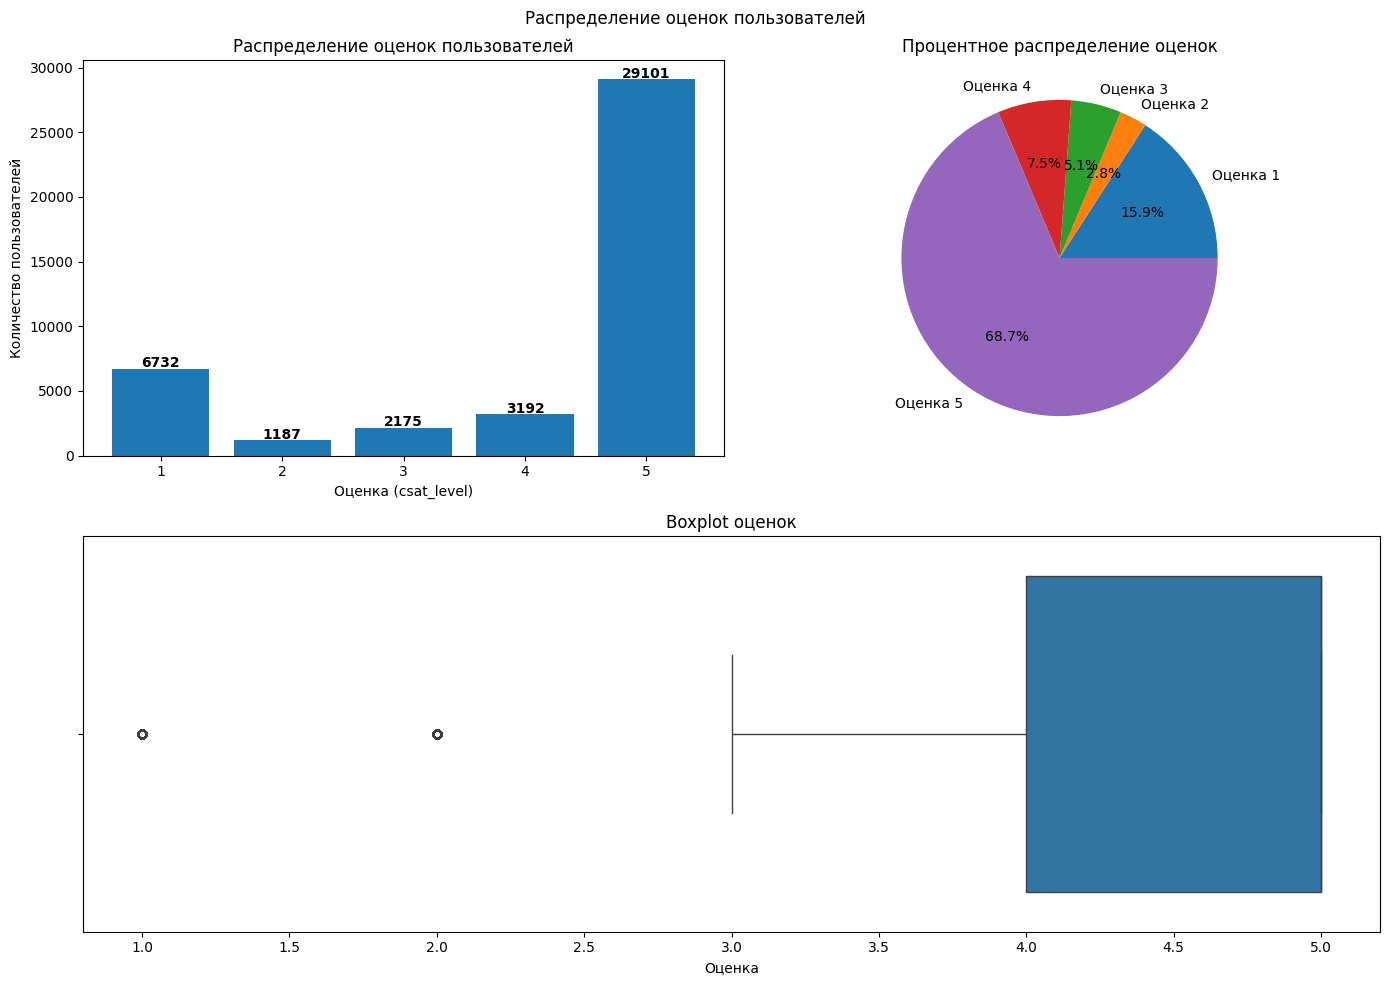

In [57]:
# Базовая статистика
print("Базовая статистика:")
csat_stats = app_survey['csat_level'].describe()
display(csat_stats)

# Распределение оценок
print("\nРаспределение оценок:")
csat_distribution = app_survey['csat_level'].value_counts().sort_index()
csat_percentage = (csat_distribution / len(app_survey) * 100).round(2)

distribution_df = pd.DataFrame({
    'Количество': csat_distribution,
    'Процент': csat_percentage,
})
display(distribution_df)

# Подробная статистика оценок 
print("\nКлючевые метрики:")

total_users = len(app_survey)
positive_reviews = len(app_survey[app_survey['csat_level'] >= 4])
negative_reviews = len(app_survey[app_survey['csat_level'] < 3])

csat_score = app_survey['csat_level'].mean()

print(f"\nОбщее количество оценок: {total_users:,}")
print(f"Средняя оценка: {csat_score:.2f}")
print(f"\nПоложительные оценки (4-5): {positive_reviews:,} ({positive_reviews/total_users*100:.1f}%)")
print(f"Нейтральные оценки (3): {len(app_survey[app_survey['csat_level'] == 3]):,} ({len(app_survey[app_survey['csat_level'] == 3])/total_users*100:.1f}%)")
print(f"Негативные оценки (1-2): {negative_reviews:,} ({negative_reviews/total_users*100:.1f}%)")

# Визуализация распределения оценок
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Гистограмма распределения
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(distribution_df.index, distribution_df['Количество'])
ax1.set_title('Распределение оценок пользователей')
ax1.set_xlabel('Оценка (csat_level)')
ax1.set_ylabel('Количество пользователей')

# Добавляем значения на столбцы
for i, v in enumerate(distribution_df['Количество']):
    ax1.text(i + 1, v + 100, str(int(v)), 
             ha='center', fontweight='bold')

# Круговая диаграмма
ax2 = fig.add_subplot(gs[0, 1])
wedges, texts, autotexts = ax2.pie(
    distribution_df['Процент'], 
    labels=[f'Оценка {i}' for i in distribution_df.index],
    autopct='%1.1f%%'
)
ax2.set_title('Процентное распределение оценок')

# Боксплот
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(data=app_survey, x='csat_level', ax=ax3)
ax3.set_title('Boxplot оценок')
ax3.set_xlabel('Оценка')

plt.suptitle('Распределение оценок пользователей')
plt.tight_layout()
plt.show()

**8. Анализ категориальных признаков**

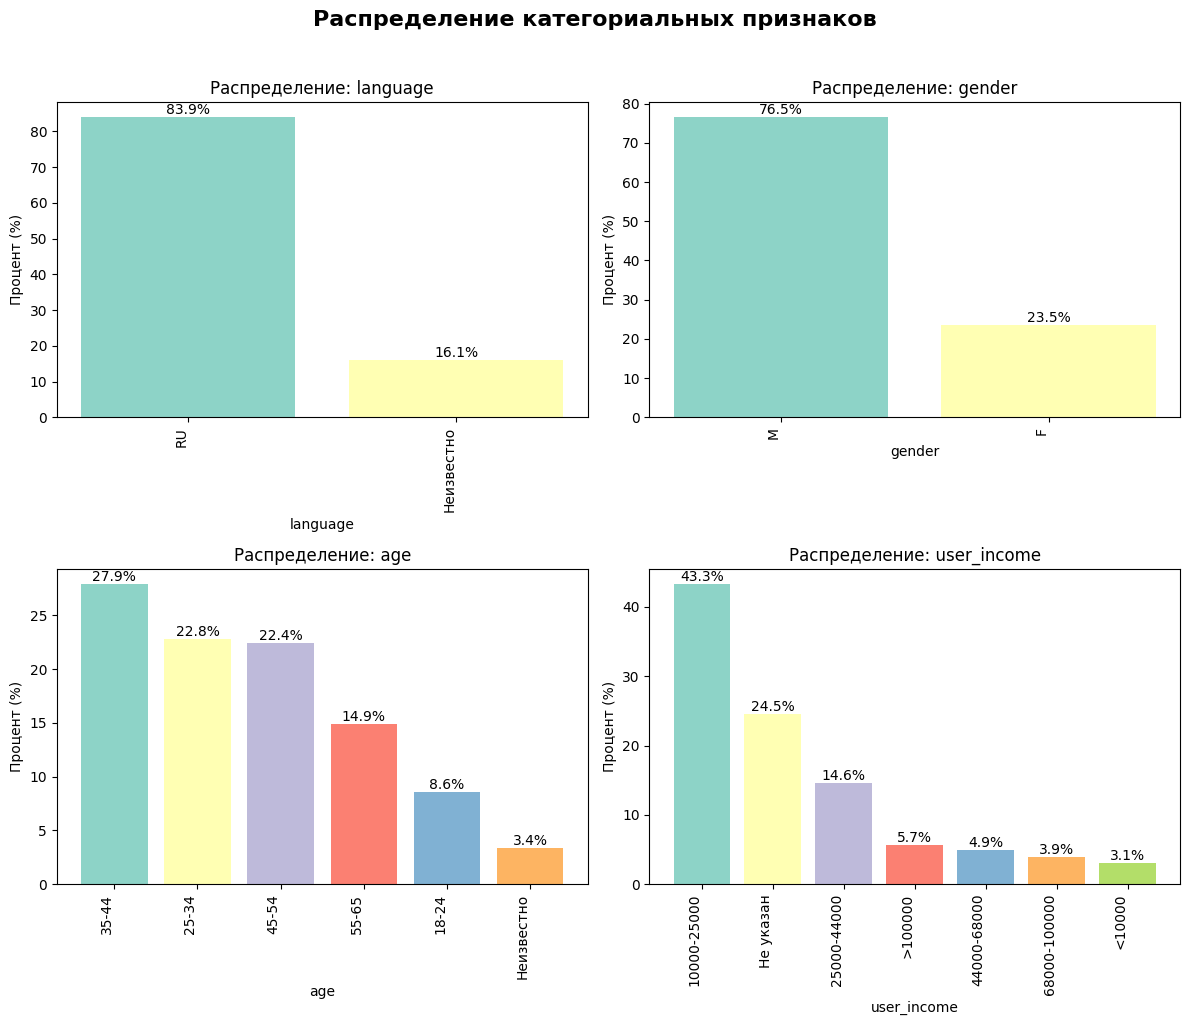

Влияние возраста на оценки:


,Средняя оценка,Количество,Стандартное отклонение,% Негативных
age,,,,
55-65,4.17,6312,1.45,17.09
45-54,4.15,9483,1.47,17.74
35-44,4.14,11835,1.48,17.63
Неизвестно,4.13,1448,1.45,16.99
25-34,4.03,9669,1.56,20.55
18-24,3.91,3640,1.61,23.05



Влияние дохода на оценки:


,Средняя оценка,Количество,Стд отклонение,% Негативных
user_income,,,,
10000-25000,4.24,18354,1.40,15.09
<10000,4.22,1299,1.42,15.70
25000-44000,4.20,6206,1.45,16.65
44000-68000,3.95,2095,1.60,22.29
>100000,3.92,2418,1.58,22.87
Не указан,3.90,10374,1.64,24.03
68000-100000,3.88,1641,1.61,24.38


In [58]:
categorical_cols = ['language', 'gender', 'age', 'user_income']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    
    # Распределение
    value_counts = app_survey[col].value_counts()
    percentages = (value_counts / len(app_survey) * 100).round(1)
    
    # Столбчатая диаграмма
    bars = ax.bar(range(len(value_counts)), percentages.values, 
                  color=plt.cm.Set3(np.arange(len(value_counts))))
    
    ax.set_title(f'Распределение: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Процент (%)')
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=90, ha='right')
    
    # Добавляем значения на столбцы
    for i, pct in enumerate(percentages.values):
        ax.text(i, pct, f'{pct}%', 
                ha='center', va='bottom')

plt.suptitle('Распределение категориальных признаков', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Детальный анализ признаков
# Создаем сегменты
app_survey['csat_segment'] = pd.cut(
    app_survey['csat_level'],
    bins=[0, 2, 3, 5],
    labels=['Негативные (1-2)', 'Нейтральные (3)', 'Положительные (4-5)'])

# Влияние возраста на оценки
age_csat = app_survey.groupby('age').agg({
    'csat_level': ['mean', 'count', 'std'],
    'csat_segment': lambda x: (x == 'Негативные (1-2)').sum() / len(x) * 100
}).round(2)

age_csat.columns = ['Средняя оценка', 'Количество', 'Стандартное отклонение', '% Негативных']
age_csat = age_csat.sort_values('Средняя оценка', ascending=False)

print("Влияние возраста на оценки:")
display(age_csat)

# Влияние дохода на оценки
income_csat = app_survey.groupby('user_income').agg({
    'csat_level': ['mean', 'count', 'std'],
    'csat_segment': lambda x: (x == 'Негативные (1-2)').sum() / len(x) * 100
}).round(2)

income_csat.columns = ['Средняя оценка', 'Количество', 'Стд отклонение', '% Негативных']
income_csat = income_csat.sort_values('Средняя оценка', ascending=False)

print("\nВлияние дохода на оценки:")
display(income_csat)

**9. Анализ числовых признаков и временных данных**

Анализ стажа пользователей:

Статистика по стажу пользователей:
Средний стаж: 9.8 лет
Медианный стаж: 9.3 лет
Минимальный стаж: 0.0 лет
Максимальный стаж: 21.2 лет

Анализ времени отклика на опрос:
Аномальные значения: 18400 оценок получено до создания опроса
Для исправления аномальных значений времени, будем считать разницу во времени по модулю

Статистика по времени отклика:
Среднее время отклика: 7.2 дней
Медианное время отклика: 6.0 дней
Минимальное время отклика: 0.0 дней
Максимальное время отклика: 31.0 дней

Корреляция времени отклика с оценкой:
Корреляция: -0.005
Слабая связь между временем отклика и оценкой


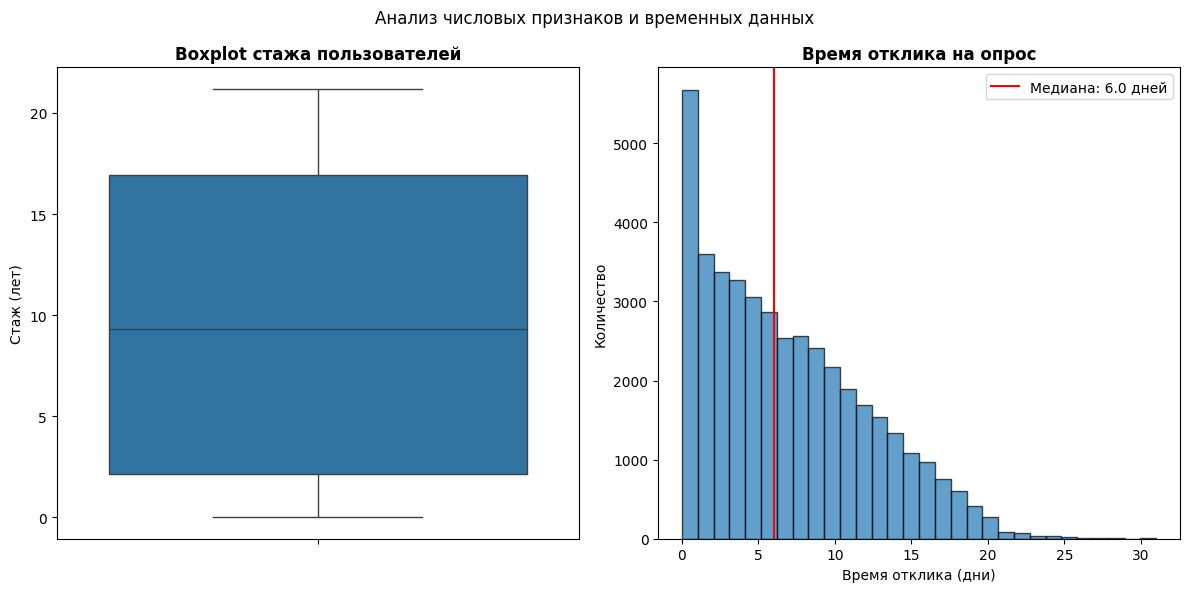

In [59]:
# Анализ стажа пользователей
print("Анализ стажа пользователей:")

# Статистики по стажу пользователей
print("\nСтатистика по стажу пользователей:")
tenure_years_stats = app_survey['tenure_years'].describe()

print(f"Средний стаж: {tenure_years_stats['mean']:.1f} лет")
print(f"Медианный стаж: {tenure_years_stats['50%']:.1f} лет")
print(f"Минимальный стаж: {tenure_years_stats['min']:.1f} лет")
print(f"Максимальный стаж: {tenure_years_stats['max']:.1f} лет")

# Анализ времени отклика
print("\nАнализ времени отклика на опрос:")

# Отрицательные значения времени (отклик раньше опроса)
negative_time = app_survey[app_survey['response_time_days'] < 0]
print(f"Аномальные значения: {len(negative_time)} оценок получено до создания опроса")
print("Для исправления аномальных значений времени, будем считать разницу во времени по модулю")

# Чтобы исправить аномалии (отрицательные значения времени) берем разницу по модулю
app_survey['response_time_days_abs'] = app_survey['response_time_days'].abs()

# Статистики по времени
print("\nСтатистика по времени отклика:")
response_stats = app_survey['response_time_days_abs'].describe()
print(f"Среднее время отклика: {response_stats['mean']:.1f} дней")
print(f"Медианное время отклика: {response_stats['50%']:.1f} дней")
print(f"Минимальное время отклика: {response_stats['min']:.1f} дней")
print(f"Максимальное время отклика: {response_stats['max']:.1f} дней")

# Анализ корреляции времени ответа с оценкой
print("\nКорреляция времени отклика с оценкой:")
corr_time_csat = app_survey[['response_time_days_abs', 'csat_level']].corr().iloc[0, 1]
print(f"Корреляция: {corr_time_csat:.3f}")
if abs(corr_time_csat) > 0.1:
    print(f"Заметная связь между временем отклика и оценкой")
else:
    print("Слабая связь между временем отклика и оценкой")

# Визуализация распределения числовых и временных признаков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot стажа
sns.boxplot(y=app_survey['tenure_years'], ax=axes[0])
axes[0].set_title('Boxplot стажа пользователей', fontweight='bold')
axes[0].set_ylabel('Стаж (лет)')

# Гистограмма времени отклика
axes[1].hist(app_survey['response_time_days_abs'], bins=30, 
             edgecolor='black', alpha=0.7)
axes[1].set_title('Время отклика на опрос', fontweight='bold')
axes[1].set_xlabel('Время отклика (дни)')
axes[1].set_ylabel('Количество')
axes[1].axvline(app_survey['response_time_days_abs'].median(), 
                color='red', linestyle='-', 
                label=f'Медиана: {app_survey["response_time_days_abs"].median():.1f} дней')
axes[1].legend()

plt.suptitle('Анализ числовых признаков и временных данных')
plt.tight_layout()
plt.show()

*Ищем аномальные сочетания возраста и стажа пользователя*

In [60]:
# Проверим аномальность данных в сочетании стажа и возраста
# Отфильтруем пользователей, у которых стаж больше 20 лет, а возраст менее 25 лет
filtered_rows = app_survey[(app_survey['tenure_years'] > 20) & (app_survey['age'] == '18-24')]
print(f"Найдено {filtered_rows.shape[0]} пользователей с аномальным сочетанием стажа и возраста")

# Посмотрим у этих пользователей остальные признаки.
selected_columns = ['user_id', 'csat_level', 'language', 'age', 'tenure_years', 'user_income', 'response_time_days']
filtered_rows_selected = filtered_rows[selected_columns]

print("\nПользователи, у которых стаж больше 20 лет, а возраст менее 25 лет:")
print(filtered_rows_selected)

Найдено 10 пользователей с аномальным сочетанием стажа и возраста

Пользователи, у которых стаж больше 20 лет, а возраст менее 25 лет:
          user_id  csat_level language    age  tenure_years  user_income  \
925    user_00888           1       RU  18-24     21.168679  25000-44000   
1335   user_01285           1       RU  18-24     21.149923    Не указан   
22215  user_21582           4       RU  18-24     21.103064  44000-68000   
23082  user_22388           1       RU  18-24     21.085149    Не указан   
26766  user_25780           3       RU  18-24     20.624531  10000-25000   
28273  user_27163           1       RU  18-24     21.146582    Не указан   
29124  user_27944           5       RU  18-24     21.125277  25000-44000   
29179  user_22388           1       RU  18-24     21.133130    Не указан   
33881  user_32227           5       RU  18-24     20.249496  25000-44000   
41092  user_21582           4       RU  18-24     21.096305  44000-68000   

       response_time_days  


**Выводы по анализу и распределению данных:**

- Высокий общий уровень удовлетворенности - 68,7% пользователей поставили максимальную оценку

- Пользователи преимущественно со стажем более 9 лет

- Найдено 10 пользователей из возрастной группы 18 - 24 года, у которых стаж более 20 лет, что невозможно. У 4 из этих пользователей не указан доход, у 7 дата отклика более ранняя, чем дата опроса. Высокая вероятность того, что эти пользователи столкнулись с техническим сбоем в работе приложения. Что могло привести к низкой оценке ими приложения

- Дисбаланс по половому признаку - значительный перекос в сторону мужчин среди участников опроса

- Различия по возрастным группам - более молодые пользователи (18–24 года) больше ставят низкие оценки, возможно из-за более высоких ожиданий или проблем с приложением

---

**10. Корреляционный анализ**

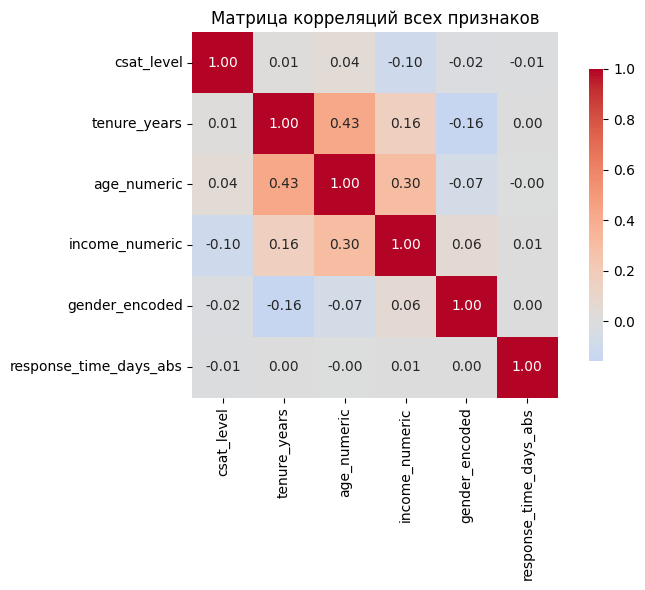


Выводы корреляционного анализа:

Значимая корреляция (> 0.1):
   • income_numeric: отрицательная связь (-0.101)


In [61]:
# Подготовка данных для корреляционного анализа
correlation_data = app_survey[[
    'csat_level',
    'tenure_years',
    'age_numeric',
    'income_numeric',
    'gender_encoded',
    'response_time_days_abs'
]].copy()

# Расчет матрицы корреляций
corr_matrix = correlation_data.corr()

# Визуализация heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            ax=ax,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
ax.set_title('Матрица корреляций всех признаков')

plt.tight_layout()
plt.show()

# Интерпретация результатов
print("\nВыводы корреляционного анализа:")

# Корреляции с целевой переменной
csat_correlations = corr_matrix['csat_level'].drop('csat_level').sort_values(ascending=False)

print("\nЗначимая корреляция (> 0.1):")
moderate_corrs = csat_correlations[(csat_correlations.abs() > 0.1) & 
                                    (csat_correlations.index != 'csat_level')]
for feature, corr in moderate_corrs.items():
    direction = "положительная" if corr > 0 else "отрицательная"
    print(f"   • {feature}: {direction} связь ({corr:.3f})")



---
**11. ОБЩИЕ ВЫВОДЫ ПО РАЗВЕДОЧНОМУ АНАЛИЗУ ДАННЫХ**
- Датасет имеет значительные пропуски, особенно в доходе (почти четверть данных) Это может указывать на технические сбои в приложении.

- Дубликаты user_id указывают на повторные опросы, что может быть связано с техническими сбоями или неудовлетворенностью пользователей.

- Аномалии во времени отклика. Отрицательный response_time_days (отклик до создания опроса) — явный технический сбой. Слишком долгий ответ (более 30 дней) — возможно проблема с уведомлениями или доступом.

- Аномалии данных в сочетании стажа и возраста пользователей (стаж сравнимый или больше, чем возраст пользователя).

- Пользователи в основном опытные (стаж более 10 лет), что коррелирует с высокой удовлетворенностью.

- Сильный перекос в сторону мужчин — возможно, приложение больше ориентировано на мужскую аудиторию или мужчины активнее участвуют в опросах.

- Аудитория среднего возраста и среднего дохода. Высокий процент пропусков в доходе может указывать на нежелание делиться данными или технические проблемы с опросом.

- Распределение оценок сильно смещено в сторону оценки 5 (68.7% от общего количества оценок)

- Молодые пользователи менее удовлетворены — возможно, ожидания выше или интерфейс приложения для них неудобен.

- Высокодоходные и неуказавшие доход пользователи менее удовлетворены. Возможно, приложение не соответствует их ожиданиям или вопрос о доходе вызывает раздражение.

- Приложение имеет высокую общую удовлетворенность, но проблемы с молодыми пользователями, высокодоходными и возможно теми, кто сталкивается с техническими сбоями (дубликаты, пропуски). Дубликаты и пропуски могут быть маркерами недовольства.

---
---
---
# II. Построение гипотез

**Гипотеза 1: есть ли связь между наличием дубликатов в user_id и низкими оценками**
- H0 (нулевая гипотеза): Наличие дубликатов (пользователь ответил несколько раз) не связано с низкими оценками

- H1 (альтернативная гипотеза): Есть статистически значимая связь между дубликатами и низкими оценками

**Гипотеза 2: связаны ли пропуски в language, age, user_income с низкими оценками**

- H0 (нулевая гипотеза): Нет связи между двумя категориальными переменными (language и csat_level (1-2), age и csat_level (1-2), user_income и csat_level (1-2))

- H1 (альтернативная гипотеза): Есть статистически значимая связь

**Гипотеза 3: связаны ли низкие оценки с определенными временными характеристиками (час создания опроса, день недели)**

- H0 (нулевая гипотеза): Нет статистически значимой связи между временными характеристиками создания опроса (день недели, час) и низкими оценками (csat_level 1-2).

- H1 (альтернативная гипотеза): Низкие оценки статистически значимо чаще встречаются в определенные периоды, что может указывать на влияние нагрузки на приложение или специфики пользовательской активности.

**Гипотеза 4: связаны ли стабильно низкие оценки у повторно отвечающих пользователей с повторяемостью их действий (время ответа, заполнение полей)?**
- H0 (нулевая гипотеза): Пользователи со стабильно низкими оценками (все ответы 1-2) не отличаются по повторяемости действий от пользователей с меняющимися оценками.

- H1 (альтернативная гипотеза): Пользователи со стабильно низкими оценками демонстрируют повторяемость действий — например, всегда отвечают через одинаковое время, всегда пропускают одни и те же поля, что может указывать на систематическую проблему в их опыте использования.

---
Для проверки выдвинутых гипотез используется классический статистический подход: каждая гипотеза формулируется в виде нулевой (H0) и альтернативной (H1), после чего подбирается критерий в зависимости от типа данных (категориальные/числовые признаки и доли).​

**1. Подготовка целевой переменной.**

- Исходная оценка csat_level (1–5) преобразуется в бинарный признак low_csat: 1 — низкая оценка (1–2), 0 — все остальные значения. Это позволит проверить гипотезы в терминах вероятности негативного отклика

**2. Выбор статистических критериев.**

- Для проверки связи между двумя категориальными признаками используется критерий хи‑квадрат Пирсона по таблицам сопряжённости

- Для сравнения распределений числовых показателей между двумя группами пользователей (например, количества откликов и числа пропусков в доходе у «стабильно недовольных» и остальных) применяется непараметрический тест Манна–Уитни, поскольку нормальность распределений не гарантирована.

**3. Уровень значимости и критерий принятия решения.**

- Уровень значимости фиксируется на α = 0.05

- Если p‑value статистического теста меньше 0.05, нулевая гипотеза отвергается и делается вывод о наличии статистически значимой связи или различий между группами. Если p‑value больше или равен 0.05, статистических оснований отвергать H0 нет, и различия трактуются как незначимые.

**4. Организация проверки по гипотезам.**

- Гипотеза 1 (дубликаты и низкие оценки): таблица 2×2 тип пользователя (single/multi) × low_csat, применяется тест хи‑квадрат.

- Гипотеза 2 (пропуски и низкие оценки): для каждого признака (language, age, user_income) строится таблица 2×2 «есть/нет пропуска × low_csat», применяется тест хи‑квадрат.

- Гипотеза 3 (время и низкие оценки): из survey_creation_dt выделяется день недели и час опроса, проводится тест хи‑квадрат для нескольких категорий.

- Гипотеза 4 (стабильно низкие оценки и поведение): на уровне user_id формируются две группы пользователей, которые ставили оценки более одного раза: одна ставящая стабильно низкие оценки, другая смешанные (stable_low_users_df vs mixed_users_df), далее выполняется тест Манна–Уитни.​

**5. Связка с визуализацией.**

- Для каждой гипотезы после статистического теста строятся наглядные графики которые позволяют визуально увидеть направление и масштаб различий, подтверждённых тестами.

---
**1. Проверка гипотезы: есть ли связь между наличием дубликатов в user_id и низкими оценками**

In [62]:
# Бинарная целевая: 1 — низкая оценка (1–2), 0 — остальное
app_survey['low_csat'] = app_survey['csat_level'].isin([1, 2]).astype(int)

user_stats = (app_survey
              .groupby('user_id')
              .agg(responses=('csat_level', 'count'),
                   low_csat_any=('low_csat', 'max')))

user_stats['group'] = np.where(user_stats['responses'] > 1, 'multi', 'single')

cont1 = pd.crosstab(user_stats['group'], user_stats['low_csat_any'])
chi2, p1, dof, exp = stats.chi2_contingency(cont1)

print('Гипотеза 1')
print(cont1)
print(f'chi2 = {chi2:.3f}, p-value = {p1:.4f}')

Гипотеза 1
low_csat_any      0     1
group                    
multi          1324   725
single        31292  6724
chi2 = 401.073, p-value = 0.0000


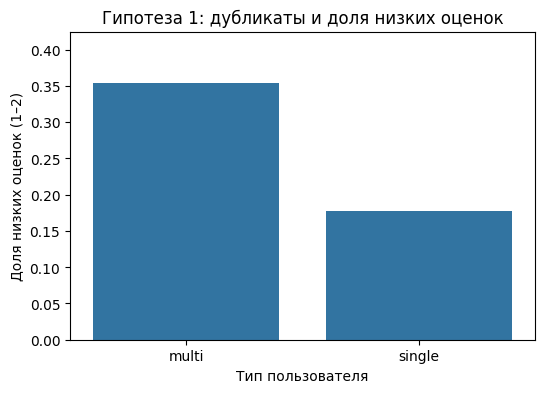

In [63]:
share1 = (user_stats
          .groupby('group')['low_csat_any']
          .mean()
          .reset_index())

plt.figure(figsize=(6, 4))
sns.barplot(data=share1, x='group', y='low_csat_any') 
plt.ylabel('Доля низких оценок (1–2)')
plt.xlabel('Тип пользователя')
plt.title('Гипотеза 1: дубликаты и доля низких оценок')
plt.ylim(0, share1['low_csat_any'].max() * 1.2)
plt.show()

In [64]:
# только пользователи с несколькими ответами
multi_df = (app_survey
            .merge(user_stats[['responses']], left_on='user_id', right_index=True)
            .query('responses > 1')
            .copy())

# сортируем по пользователю и дате
multi_df = multi_df.sort_values(['user_id', 'survey_response_dt'])

# сдвиг оценки внутри пользователя
multi_df['csat_prev'] = multi_df.groupby('user_id')['csat_level'].shift(1)
multi_df['delta_csat'] = multi_df['csat_level'] - multi_df['csat_prev']

# агрегация по пользователю
dyn_stats = (multi_df
             .groupby('user_id')
             .agg(first_csat=('csat_level', 'first'),
                  last_csat=('csat_level', 'last'),
                  mean_delta=('delta_csat', 'mean')))

dyn_stats['change'] = dyn_stats['last_csat'] - dyn_stats['first_csat']

dyn_stats['change_cat'] = pd.cut(
    dyn_stats['change'],
    bins=[-10, -0.5, 0.5, 10],
    labels=['ухудшилось', 'без изменений', 'улучшилось']
)

dyn_stats['change_cat'].value_counts(normalize=True)

change_cat
без изменений    0.715959
ухудшилось       0.159102
улучшилось       0.124939
Name: proportion, dtype: float64

        scenario     share
0  без изменений  0.715959
1     ухудшилось  0.159102
2     улучшилось  0.124939


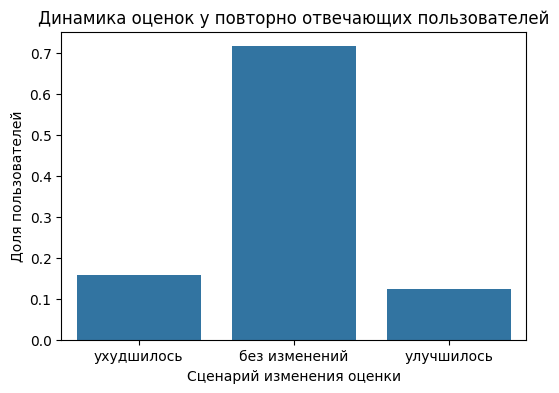

In [65]:
change_share = (dyn_stats['change_cat']
                .value_counts(normalize=True)
                .reset_index())

change_share.columns = ['scenario', 'share']  

print(change_share.head())

plt.figure(figsize=(6, 4))
sns.barplot(data=change_share, x='scenario', y='share')
plt.ylabel('Доля пользователей')
plt.xlabel('Сценарий изменения оценки')
plt.title('Динамика оценок у повторно отвечающих пользователей')
plt.show()

**Выводы:**

1. По результатам анализа нулевая гипотеза отвергается: пользователи с несколькими откликами статистически значимо чаще ставят низкие оценки (1–2), чем пользователи с одним ответом. 

2. Дополнительный разбор динамики показал, что у большинства таких пользователей оценка остаётся стабильной, однако доля тех, у кого оценка ухудшается со временем, заметно выше, чем доля улучшающих оценку (примерно 15% против 12–13% среди повторно отвечающих). Это позволяет трактовать повторные ответы не как случайный шум, а как индикатор группы более проблемных и потенциально нарастающе недовольных пользователей, на которых стоит нацеливать приоритетные улучшения продукта и UX

---
**2. Проверка гипотезы: связаны ли пропуски в language, age, user_income с низкими оценками**

In [66]:
print('\nГипотеза 2')

for col in ['language', 'age', 'user_income']:
    flag = app_survey[col].isna() | (app_survey[col] == 'Не указан') | (app_survey[col] == 'Неизвестно')
    cont = pd.crosstab(flag, app_survey['low_csat'])
    chi2, p, dof, exp = stats.chi2_contingency(cont)
    print(f'\nПризнак: {col}')
    print(cont)
    print(f'chi2 = {chi2:.3f}, p-value = {p:.4f}')


Гипотеза 2

Признак: language
low_csat      0     1
language             
False     28698  6863
True       5770  1056
chi2 = 55.013, p-value = 0.0000

Признак: age
low_csat      0     1
age                  
False     33266  7673
True       1202   246
chi2 = 2.716, p-value = 0.0993

Признак: user_income
low_csat         0     1
user_income             
False        26587  5426
True          7881  2493
chi2 = 258.185, p-value = 0.0000


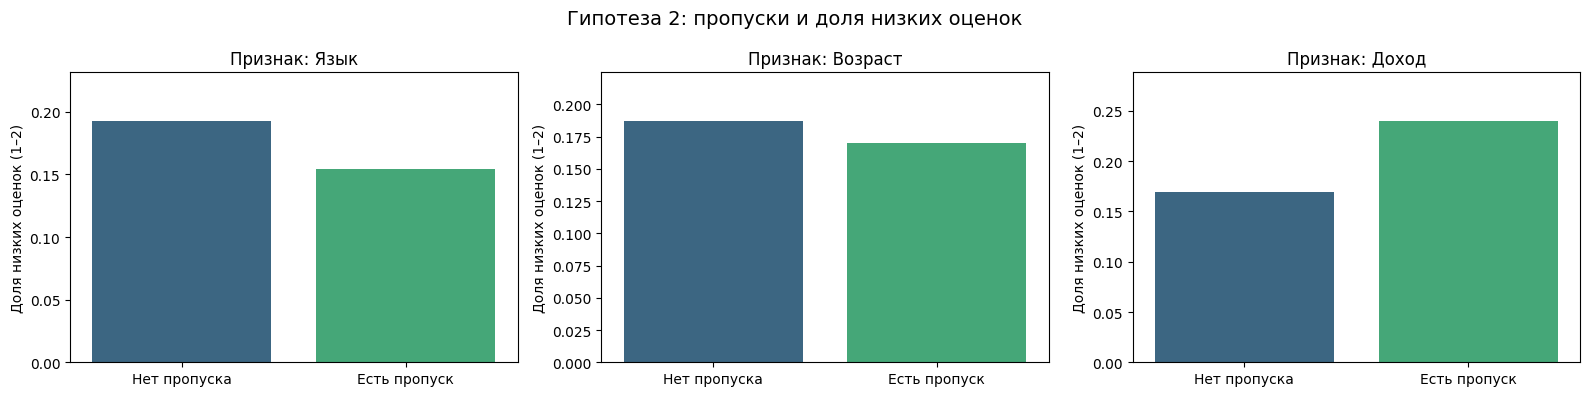

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
cols = ['language', 'age', 'user_income']
titles = ['Язык', 'Возраст', 'Доход']

for ax, col, title in zip(axes, cols, titles):
    flag = app_survey[col].isna() | (app_survey[col].isin(['Не указан', 'Неизвестно']))
    temp = (app_survey
            .assign(missing=flag)
            .groupby('missing')['low_csat']
            .mean()
            .reset_index())

    temp['missing_label'] = temp['missing'].map({False: 'Нет пропуска', True: 'Есть пропуск'})

    sns.barplot(data=temp,
                x='missing_label',
                y='low_csat',
                hue='missing_label',
                palette='viridis',
                legend=False,
                ax=ax)

    ax.set_title(f'Признак: {title}')
    ax.set_xlabel('')
    ax.set_ylabel('Доля низких оценок (1–2)')
    ax.set_ylim(0, temp['low_csat'].max() * 1.2)

plt.suptitle('Гипотеза 2: пропуски и доля низких оценок', fontsize=14)
plt.tight_layout()
plt.show()

In [68]:
# признаки для кластеров
features = ['gender_encoded', 'age_numeric', 'income_numeric']
X = app_survey[features].dropna().copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

app_survey_clusters = app_survey.loc[X.index].copy()
app_survey_clusters['cluster'] = clusters

In [69]:
# Количество оценок по кластерам и уровням
counts = (app_survey_clusters
          .groupby(['cluster', 'csat_level'])['user_id']
          .count()
          .reset_index(name='cnt'))

print('Количество оценок по кластерам и уровням:')
print(counts.head(20))

# доли внутри кластера
counts['share'] = counts['cnt'] / counts.groupby('cluster')['cnt'].transform('sum')
dist_by_cluster = counts[['cluster', 'csat_level', 'share']]

# Средняя оценка и размер кластера
csat_by_cluster = (app_survey_clusters
                   .groupby('cluster')['csat_level']
                   .agg(['count', 'mean'])
                   .reset_index())

print('\nСредняя оценка и размер кластера:')
print(csat_by_cluster)

Количество оценок по кластерам и уровням:
    cluster  csat_level   cnt
0         0           1  1511
1         0           2   242
2         0           3   459
3         0           4   624
4         0           5  5899
5         1           1  1559
6         1           2   254
7         1           3   504
8         1           4   650
9         1           5  5922
10        2           1  1387
11        2           2   258
12        2           3   382
13        2           4   519
14        2           5  4355
15        3           1  1394
16        3           2   235
17        3           3   540
18        3           4   873
19        3           5  8508

Средняя оценка и размер кластера:
   cluster  count      mean
0        0   8735  4.048426
1        1   8889  4.026212
2        2   6901  3.897986
3        3  11550  4.287100


In [70]:
# Определяем состав кластеров
# Подключаем исходные категориальные признаки
detailed_clusters = app_survey.loc[X.index].copy()
detailed_clusters['cluster'] = clusters

print("\nРаспределение пола по кластерам:")
gender_dist = pd.crosstab(detailed_clusters['cluster'], detailed_clusters['gender'], normalize='index')
print(gender_dist.round(3) * 100)

print("\nРаспределение возрастных групп по кластерам:")
age_dist = pd.crosstab(detailed_clusters['cluster'], detailed_clusters['age'], normalize='index')
print(age_dist.round(3) * 100)

print("\nРаспределение доходов по кластерам:")
income_dist = pd.crosstab(detailed_clusters['cluster'], detailed_clusters['user_income'], normalize='index')
print(income_dist.round(3) * 100)


Распределение пола по кластерам:
gender       F      M
cluster              
0        100.0    0.0
1          0.0  100.0
2          2.7   97.3
3          0.0  100.0

Распределение возрастных групп по кластерам:
age      18-24  25-34  35-44  45-54  Неизвестно
cluster                                        
0         10.5   31.7   35.6   21.8         0.3
1         30.6   69.4    0.0    0.0         0.0
2          0.0   10.6   25.8   46.6        17.0
3          0.0    0.0   60.1   37.8         2.1

Распределение доходов по кластерам:
user_income  10000-25000  25000-44000  44000-68000  68000-100000  <10000  \
cluster                                                                    
0                   49.4         14.4          2.9           3.3     0.3   
1                   68.8         16.7          2.7           0.7     5.6   
2                    0.0          0.0          0.4          13.8     0.0   
3                   58.1         25.3         10.6           0.0     6.1   

user_i

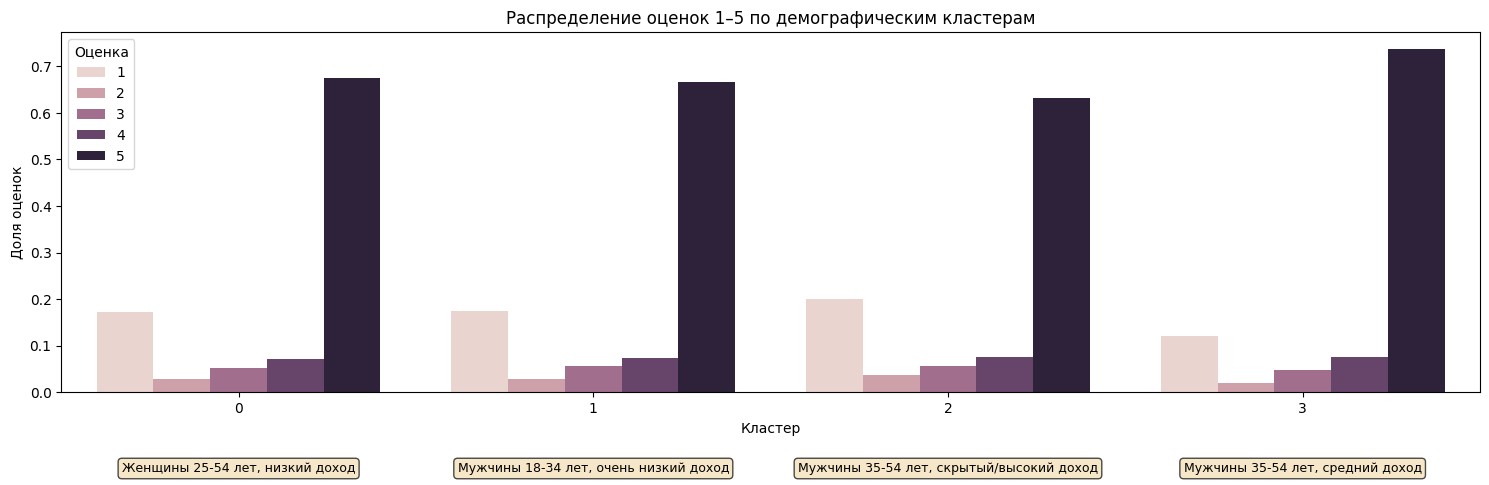

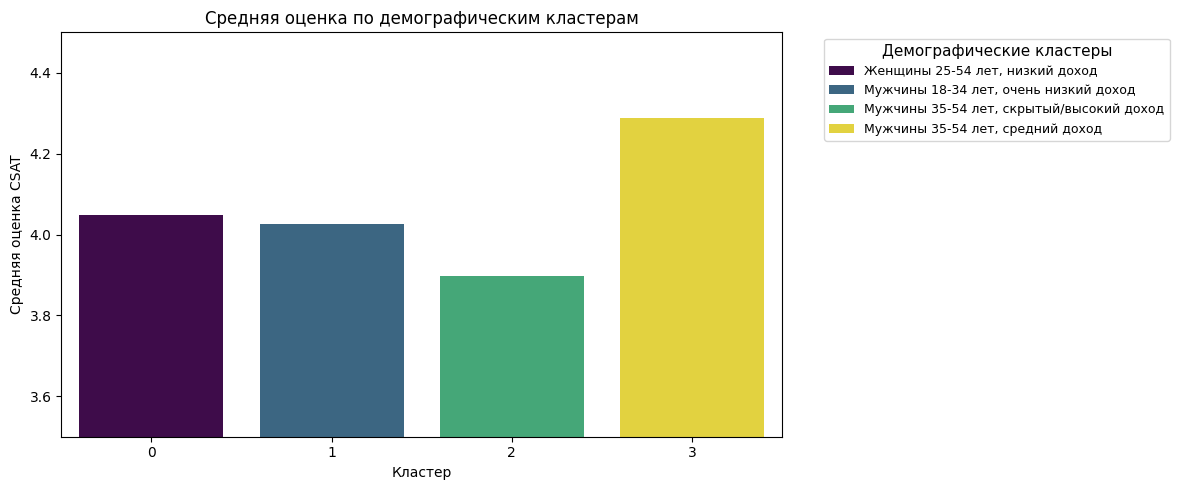

In [71]:
# Расшифровка кластеров
cluster_labels = {
    0: "Женщины 25-54 лет, низкий доход",
    1: "Мужчины 18-34 лет, очень низкий доход",
    2: "Мужчины 35-54 лет, скрытый/высокий доход",
    3: "Мужчины 35-54 лет, средний доход"
}

# распределение оценок 1–5 по кластерам
plt.figure(figsize=(15, 5))
sns.barplot(data=dist_by_cluster,
            x='cluster', y='share', hue='csat_level')
plt.ylabel('Доля оценок')
plt.xlabel('Кластер')
plt.title('Распределение оценок 1–5 по демографическим кластерам')
plt.legend(title='Оценка')

# Добавляем расшифровку кластеров на график
for i in range(4):
    plt.text(i, -0.15, cluster_labels[i], 
             ha='center', va='top', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.7))

plt.tight_layout()
plt.show()

# средняя оценка по кластерам 
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=csat_by_cluster,
            x='cluster', y='mean',
            hue='cluster', palette='viridis', legend=True)

plt.ylabel('Средняя оценка CSAT')
plt.xlabel('Кластер')
plt.title('Средняя оценка по демографическим кластерам')
plt.ylim(3.5, 4.5)

# Добавляем расшифровку кластеров на график
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, [cluster_labels[i] for i in range(4)], 
          title='Демографические кластеры', title_fontsize=11, fontsize=9,
          bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Выводы:**

1. По результатам проверки нулевая гипотеза частично отвергается: 

- Пользователи, у которых не указан язык, статистически значимо чаще ставят низкие оценки (1-2 балла)

- Пропуск возраста не связан с низкими оценками

- Пользователи, которые не указали доход, чаще ставят низкие оценки

2. Дополнительный анализ с кластеризацией пользователей по демографическим признакам показал:

- Кластер 2: Мужчины старшего возраста со скрытым/высоким доходом - самый недовольный. Мужчины 35-54 лет, высокая доля скрывающих доход (63.8%), но среди открывших — много высокооплачиваемых (22% указали более 100K)

        Удовлетворённость: Средняя оценка: 3.90 (самая низкая); 5-звёздочных оценок: 4355 из 6901 (63.1%) - минимальный процент; 1-звёздочных оценок: 1387 (20.1%) - самый высокий процент.

- Кластер 3 (мужчины 35-54 со средним доходом) — идеальная целевая аудитория, стоит фокусировать маркетинг и удержание.

        Удовлетворённость: Средняя оценка: 4.29 (самая высокая); 5-звёздочных оценок: 8508 из 11550 (73.7%) - максимальный показатель; 1-звёздочных оценок: 1394 (12.1%) - минимальный процент недовольных.

---

**3. Проверка гипотезы: связаны ли низкие оценки с определенными временными характеристиками (час создания опроса, день недели)**

*Выбор статистического теста:*

- Проверяемые признаки являются категориальными

- Объем данных ~ 40 000 строк

Для данных условий подходит Хи-квадрат тест

In [72]:
# Создаем признаки для часа и дня проведения опроса
app_survey['creation_hour'] = app_survey['survey_creation_dt'].dt.hour
app_survey['creation_weekday'] = app_survey['survey_creation_dt'].dt.day_name()

# Создаем признак 'низкий рейтинг', который включает в себя все оценки ниже 3
app_survey['low_rating'] = (app_survey['csat_level'] <= 2).astype(int)

# Функция для хи-квадрат
def chi_square_test(df, feature_col, target_col='low_rating'):
    contingency_table = pd.crosstab(df[feature_col], df[target_col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2, p_value, contingency_table

# Проверяем связь низких оценок с часом создания опроса
chi2_hour, p_hour, table_hour = chi_square_test(app_survey, 'creation_hour')
print("Результаты проверки для часа создания опроса:")
print(f"chi2 = {chi2_hour:.3f}, p-value = {p_hour:.4f}")
print(f"Статистически значимо: {p_hour < 0.05}\n")
print(table_hour)

# Проверяем связь низких оценок с днем недели создания опроса
chi2_day, p_day, table_day = chi_square_test(app_survey, 'creation_weekday')
print("\nРезультаты для дня недели создания опроса:")
print(f"chi^2 = {chi2_day:.3f}, p-value = {p_day:.4f}")
print(f"Статистически значимо: {p_day < 0.05}\n")
print(table_day)

Результаты проверки для часа создания опроса:
chi2 = 226.965, p-value = 0.0000
Статистически значимо: True

low_rating        0    1
creation_hour           
0              1526  419
1              1565  430
2              1575  385
3              1744  446
4              1925  518
5              1935  410
6              1888  343
7              2343  506
8              1746  341
9              1819  320
10             1770  337
11             1860  330
12             1806  388
13             1470  305
14             1529  501
15             1016  196
16              828  182
17              706  134
18              615  119
19              621  139
20              696  196
21              792  174
22             1148  363
23             1545  437

Результаты для дня недели создания опроса:
chi^2 = 3.785, p-value = 0.7058
Статистически значимо: False

low_rating           0     1
creation_weekday            
Friday            4850  1154
Monday            5011  1140
Saturday          50

Рассмотрим распределение доли низких оценок по часам, чтобы определить возможные пиковые часы нагрузки на приложение.

Средняя доля низких оценок: 18.65%
Часы с долей низких оценок выше средней:
    creation_hour  low_rating_pcnt  total_ratings
0               0        21.542416           1945
1               1        21.553885           1995
2               2        19.642857           1960
3               3        20.365297           2190
4               4        21.203438           2443
14             14        24.679803           2030
20             20        21.973094            892
22             22        24.023825           1511
23             23        22.048436           1982


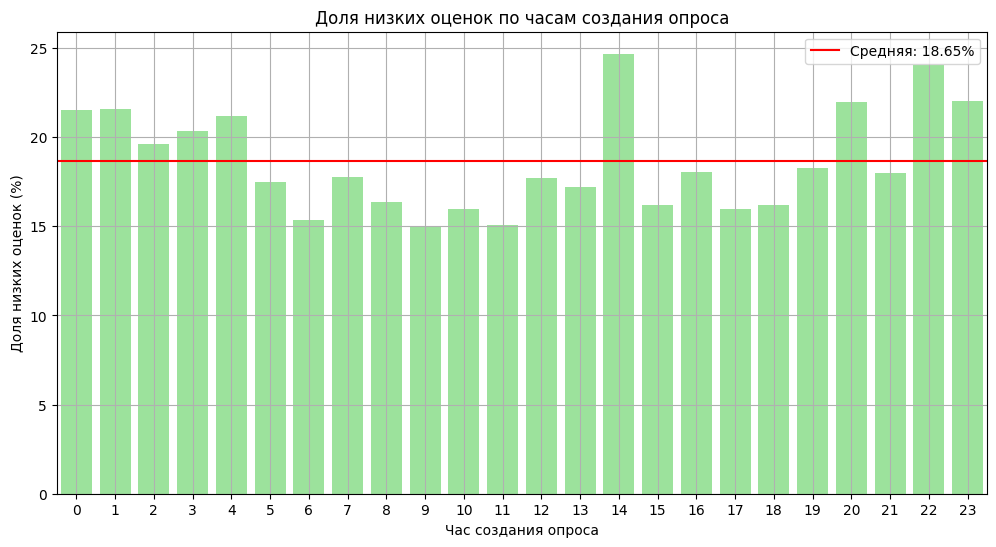

In [73]:
# Рассчитываем долю низких оценок по часам
hour_analys = app_survey.groupby('creation_hour').agg(
    total_ratings=('low_rating', 'count'),
    low_ratings=('low_rating', 'sum')
).reset_index()

# доля низких оценок
hour_analys['low_rating_pcnt'] = (hour_analys['low_ratings'] / hour_analys['total_ratings']) * 100

# Средняя доля низких оценок
mean_low_pcnt = hour_analys['low_rating_pcnt'].mean()

# Часы с долей выше средней
high_low_hours = hour_analys[hour_analys['low_rating_pcnt'] > mean_low_pcnt]

print(f"Средняя доля низких оценок: {mean_low_pcnt:.2f}%")
print("Часы с долей низких оценок выше средней:")
print(high_low_hours[['creation_hour', 'low_rating_pcnt', 'total_ratings']])

# Визуализация доли низких оценок по часам
plt.figure(figsize=(12, 6))
sns.barplot(data=hour_analys, x='creation_hour', y='low_rating_pcnt', color='lightgreen')
plt.axhline(y=mean_low_pcnt, color='red', label=f'Средняя: {mean_low_pcnt:.2f}%')
plt.title('Доля низких оценок по часам создания опроса')
plt.xlabel('Час создания опроса')
plt.ylabel('Доля низких оценок (%)')
plt.legend()
plt.grid()
plt.show()

**Вывод:**

1. Низкие оценки статистически значимо чаще встречаются в определенные часы создания опроса (p < 0.05), но не зависят от дня недели (p = 0.706). 

2. Часы с повышенной долей низких оценок: 0, 1, 3, 4, 14, 20, 22, 23. Это может быть обусловлено нагрузкой на приложение, техническими сбоями или поведенческими факторами (усталость пользователей в поздние или ранние часы).

**Рекомендации для ML отдела:**
Включить признак 'час создания опроса' как категориальный признак (1, если час в списке 'рискованных часов' и 0 для остальных часов). Модель может прогнозировать вероятность низкой оценки на основе времени, что позволит оптимизировать время показа рекламы и минимизировать риск негативной реакции пользователей

---

**4. Проверка гипотезы: связаны ли стабильно низкие оценки у повторно отвечающих пользователей с повторяемостью их действий (время ответа, заполнение полей)?**

In [74]:
# Находим пользователей с несколькими ответами
user_response_cnt = app_survey["user_id"].value_counts()
repeat_user_ids = user_response_cnt[user_response_cnt > 1].index

# Создаем датасет, куда добавляем только повторно отвечающих пользователей
df_repeat_users = app_survey[app_survey['user_id'].isin(repeat_user_ids)].copy()

print(f"Пользователи с несколькими ответами: {len(repeat_user_ids)}")
print(
    f"Процент повторных пользователей: {len(repeat_user_ids)/len(user_response_cnt)*100:.2f}%"
)

# Классификация пользователей по паттернам оценок
def classify_user_type(ratings_series):
    """Классифицирует пользователя по паттернам оценок на основе серии оценок.

    Args:
        ratings_series (pd.Series): Серия оценок пользователя (от 1 до 5)

    Returns:
        str: Тип пользователя на основе паттернов оценок
    """
    ratings = ratings_series.tolist()
    all_low = all(r <= 2 for r in ratings)
    all_high = all(r >= 4 for r in ratings)
    if all_low:
        return "Стабильно низкие оценки (1 или 2)"
    elif all_high:
        return "Стабильно высокие оценки (4 или 5)"
    else:
        return "Смешанные оценки"

# Группируем по user_id и применяем классификацию
repeat_users_df = df_repeat_users.sort_values("survey_response_dt").groupby("user_id").agg(
    user_type=('csat_level', classify_user_type),
    num_responses=('csat_level', 'count'),
    ratings=('csat_level', lambda x: x.tolist())
).reset_index()

# Статистика по типам пользователей
type_distribution = repeat_users_df["user_type"].value_counts()
print("\nРаспределение пользователей по типам оценок:")
for user_type, count in type_distribution.items():
    print(
        f"{user_type}: {count} пользователей ({count/len(repeat_users_df)*100:.2f}%)"
    )

# Выделяем группы для дальнейшего сравнения
stable_low_users_df = repeat_users_df[repeat_users_df["user_type"] == "Стабильно низкие оценки (1 или 2)"]
mixed_users_df = repeat_users_df[repeat_users_df["user_type"] == "Смешанные оценки"]

stable_low_user_ids = stable_low_users_df["user_id"].tolist()
mixed_user_ids = mixed_users_df["user_id"].tolist()

print(f"\nДля теста используем:")
print(f"Стабильно низкие оценки: {len(stable_low_user_ids)} пользователей")
print(f"Смешанные оценки: {len(mixed_user_ids)} пользователей")

Пользователи с несколькими ответами: 2049
Процент повторных пользователей: 5.11%

Распределение пользователей по типам оценок:
Стабильно высокие оценки (4 или 5): 1194 пользователей (58.27%)
Смешанные оценки: 469 пользователей (22.89%)
Стабильно низкие оценки (1 или 2): 386 пользователей (18.84%)

Для теста используем:
Стабильно низкие оценки: 386 пользователей
Смешанные оценки: 469 пользователей


In [75]:
# Анализ повторяемости времени ответа
# Получаем время ответа для каждой группы
stable_low_times_all = df_repeat_users[df_repeat_users['user_id'].isin(stable_low_user_ids)]['response_time_days_abs'].tolist()
mixed_times_all = df_repeat_users[df_repeat_users['user_id'].isin(mixed_user_ids)]['response_time_days_abs'].tolist()

# Рассчитываем стандартное отклонение для пользователей с несколькими ответами
stable_low_consistency = df_repeat_users[df_repeat_users['user_id'].isin(stable_low_user_ids)] \
                            .groupby('user_id')['response_time_days_abs'] \
                            .agg(lambda x: np.std(x) if len(x) > 1 else np.nan) \
                            .dropna().tolist()

mixed_consistency = df_repeat_users[df_repeat_users['user_id'].isin(mixed_user_ids)] \
                       .groupby('user_id')['response_time_days_abs'] \
                       .agg(lambda x: np.std(x) if len(x) > 1 else np.nan) \
                       .dropna().tolist()

print("\nСтабильно низкие оценки:")
if stable_low_times_all:
    print(f"Среднее время ответа: {np.mean(stable_low_times_all):.1f} дней")
    print(f"Медианное время ответа: {np.median(stable_low_times_all):.1f} дней")
if stable_low_consistency:
    print(f"Среднее стандартное отклонение: {np.mean(stable_low_consistency):.1f} дней")
    print(f"Количество пользователей с повторными ответами: {len(stable_low_consistency)}")

print("\nСмешанные оценки:")
if mixed_times_all:
    print(f"Среднее время ответа: {np.mean(mixed_times_all):.1f} дней")
    print(f"Медианное время ответа: {np.median(mixed_times_all):.1f} дней")
if mixed_consistency:
    print(f"Среднее стандартное отклонение: {np.mean(mixed_consistency):.1f} дней")
    print(f"Количество пользователей с повторными ответам: {len(mixed_consistency)}")


Стабильно низкие оценки:
Среднее время ответа: 6.9 дней
Медианное время ответа: 6.0 дней
Среднее стандартное отклонение: 0.9 дней
Количество пользователей с повторными ответами: 386

Смешанные оценки:
Среднее время ответа: 6.8 дней
Медианное время ответа: 6.0 дней
Среднее стандартное отклонение: 0.9 дней
Количество пользователей с повторными ответам: 469


*Выбор статистического теста:*

- Сравниваются две независимые группы

- Данные не имеют нормального распределения

Для данных условий подходит статистический тест Манна-Уитни

In [76]:
# Статистический тест для общего времени ответа
if stable_low_times_all and mixed_times_all:
    statistic, p_value = mannwhitneyu(
        stable_low_times_all, mixed_times_all, alternative="two-sided"
    )
    print(f"\nТест Манна-Уитни для времени ответа:")
    print(f"p-value: {p_value:.6f}")
    print(f"Статистически значимо: {p_value < 0.05}")


Тест Манна-Уитни для времени ответа:
p-value: 0.725219
Статистически значимо: False


In [77]:
# Анализ повторяемости заполнения полей
fields_to_check = ["language", "age", "user_income"]
field_results = {}

for field in fields_to_check:
    # Рассчитываем стандартное отклонение для пользователей со стабильно низкими оценками
    stable_consistency_series = df_repeat_users[df_repeat_users['user_id'].isin(stable_low_user_ids)] \
                                .groupby('user_id')[field].agg('nunique')

    stable_consistent_count = (stable_consistency_series == 1).sum()
    stable_total_count = len(stable_consistency_series)
    stable_rate = stable_consistent_count / stable_total_count

    # Рассчитываем стандартное отклонение для пользователей со смешанными оценками
    mixed_consistency_series = df_repeat_users[df_repeat_users['user_id'].isin(mixed_user_ids)] \
                               .groupby('user_id')[field].agg('nunique')

    mixed_consistent_count = (mixed_consistency_series == 1).sum()
    mixed_total_count = len(mixed_consistency_series)
    mixed_rate = mixed_consistent_count / mixed_total_count

    field_results[field] = {
        "stable_rate": stable_rate,
        "mixed_rate": mixed_rate,
        "stable_total": stable_total_count,
        "mixed_total": mixed_total_count,
    }
    
    print(f"\nПризнак: {field}")
    print(
        f"Стабильно низкие оценки: {stable_rate:.2%} ({stable_consistent_count}/{stable_total_count})"
    )
    print(f"Смешанные оценки: {mixed_rate:.2%} ({mixed_consistent_count}/{mixed_total_count})")  
    
    # Используем тест ХИ-квадрат для сравнения долей
    contingency_table = np.array([
            [stable_consistent_count, stable_total_count - stable_consistent_count],
            [mixed_consistent_count, mixed_total_count - mixed_consistent_count],
        ])
    
    try:
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        print(f"Хи-квадрат тест p-value: {p_val:.4f}")
        print(f"Статистически значимо: {pd.isna(p_val) or p_val < 0.05}")
        field_results[field]["chi2_p"] = p_val
        field_results[field]["chi2_significant"] = (pd.isna(p_val) or p_val < 0.05) and (stable_rate > mixed_rate)
    except ValueError as e:
        print(f"Недостаточно данных для хи-квадрат теста: {e}")
            
            
    


Признак: language
Стабильно низкие оценки: 100.00% (386/386)
Смешанные оценки: 100.00% (469/469)
Недостаточно данных для хи-квадрат теста: The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(1)).

Признак: age
Стабильно низкие оценки: 100.00% (386/386)
Смешанные оценки: 99.79% (468/469)
Хи-квадрат тест p-value: 1.0000
Статистически значимо: False

Признак: user_income
Стабильно низкие оценки: 98.45% (380/386)
Смешанные оценки: 94.03% (441/469)
Хи-квадрат тест p-value: 0.0019
Статистически значимо: True


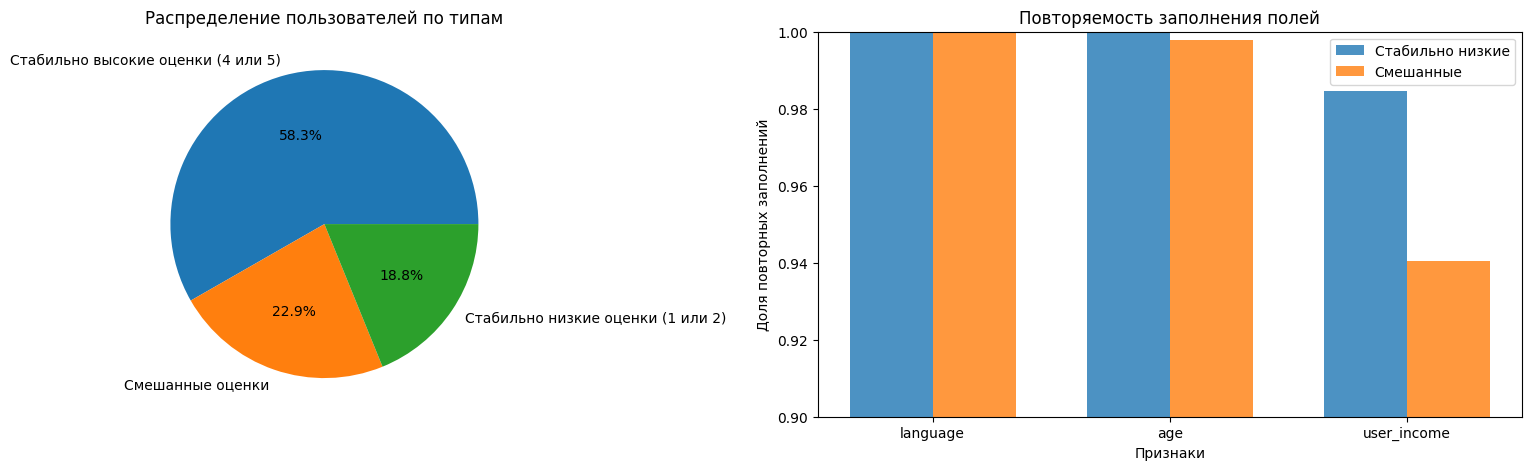

In [78]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Распределение типов пользователей
ax1 = axes[0]
type_counts = repeat_users_df["user_type"].value_counts()
wedges, texts, autotexts = ax1.pie(
        type_counts.values, labels=type_counts.index, autopct="%1.1f%%"
    )
ax1.set_title("Распределение пользователей по типам")

# Анализ повторяемости заполнения полей
ax2 = axes[1]

field_results and all(len(d) > 0 for d in [field_results[f] for f in field_results])
fields_for_plot = list(field_results.keys())
stable_rates_plot = [field_results[f]["stable_rate"] for f in fields_for_plot]
mixed_rates_plot = [field_results[f]["mixed_rate"] for f in fields_for_plot]

x = np.arange(len(fields_for_plot))
width = 0.35

ax2.bar(
    x - width / 2,
    stable_rates_plot,
    width,
    label="Стабильно низкие",
    alpha=0.8,
)
ax2.bar(
    x + width / 2,
    mixed_rates_plot,
    width,
    label="Смешанные",
    alpha=0.8
)

ax2.set_xlabel("Признаки")
ax2.set_ylabel("Доля повторных заполнений")
ax2.set_title("Повторяемость заполнения полей")
plt.ylim(0.9, 1.0)
ax2.set_xticks(x)
ax2.set_xticklabels(fields_for_plot)
ax2.legend()

plt.show()

**Вывод:**

1. Обе группы пользователей (со стабильно низкими оценками и со смешанными оценками) показывают практически идентичное поведение по времени ответа.

2. Обнаружена статистически значимая разница в заполнения данных о доходе (user_income). Это может указывать на то, что проблема с приложением затрагивает именно финансовые аспекты или взаимодействие с данными о доходах

---
---
---
# ФИНАЛЬНЫЕ ВЫВОДЫ
---

**1. Рекомендации для ML-отдела**

*Значимые признаки для модели:*

- "Рискованные" часы проведения опроса - 0, 1, 3, 4, 14, 20, 22, 23

- Дублирование ответов - наличие повторных опросов/ответов

- Пропуски в языке и доходе - значимые маркеры недовольства

- Молодой возраст - группа 18-24 года

- Согласованность в указании дохода - пользователи со стабильно низкими оценками последовательнее

- Использовать принадлежность к определенному кластеру как признак

*Незначимые признаки:*

- День недели проведения опроса - не влияет на оценки

- Пропуск возраста - не связан с низкими оценками

- Повторяемость времени ответа - незначима

- Согласованность языка и возраста - неразличима между группами

*Ключевая проблема:*

**Качество данных и технические сбои** приводят к **Недовольству пользователей**, что в свою очередь приводит к **Низким оценкам**



**2. Выводы для заказчика**

*Положительные моменты:*

- Высокая общая удовлетворенность - 68.7% пользователей ставят максимальную оценку (5 баллов)

- Опытная аудитория - пользователи со стажем более 10 лет, что коррелирует с высокой удовлетворенностью

*Негативные моменты:*

- 18.8% стабильно недовольных пользователей - систематически ставят низкие оценки

- Проблемы с молодыми пользователями (18-24 года) - чаще ставят низкие оценки

- Вопрос о доходе может вызывать раздражение - статистически значимо связан с низкими оценками

- Технические сбои - 25% пропусков в данных, дубликаты, временные аномалии

*Рекомендации:*

- Кластер 3 (мужчины 35-54 со средним доходом) использовать как референтную группу для лучших практик. Внедрить программу лояльности для этой стабильной аудитории

- Для кластера 2 (Мужчины 35-54 со скрытым/высоким доходом):

        Персональные консультации для высокооплачиваемых клиентов
        Исследование причин скрытности доходов и недовольства

- Время опросов - избегать "рискованных" часов

- Пересмотреть вопрос о доходе - сделать опциональным или изменить формулировку

- Сосредоточиться на молодых пользователях - улучшить стабильность приложения

- Устранить технические сбои - решить проблемы с дублированием опросов и аномалиями времени

- Внедрить систему работы с жалобами - для 386 стабильно недовольных пользователей

---

# ИТОГ:
**Приложение имеет высокий базовый уровень удовлетворенности, но системные проблемы с техническими сбоями и целевые группы недовольных пользователей требуют адресных улучшений. ML-модель позволит прогнозировать и предотвращать негативный опыт, повышая общую удовлетворенность.**